Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8635 - loss: 0.4119 - val_accuracy: 0.9837 - val_loss: 0.0546
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9754 - loss: 0.0788 - val_accuracy: 0.9848 - val_loss: 0.0479
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9825 - loss: 0.0537 - val_accuracy: 0.9887 - val_loss: 0.0340
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9851 - loss: 0.0468 - val_accuracy: 0.9902 - val_loss: 0.0321
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9877 - loss: 0.0383 - val_accuracy: 0.9912 - val_loss: 0.0318
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9887 - loss: 0.0357 - val_accuracy: 0.9920 - val_loss: 0.0289
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9906 - loss: 0.0300 - val_accuracy: 0.9905 - val_loss: 0.0338
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9902 - loss: 0.0288 -

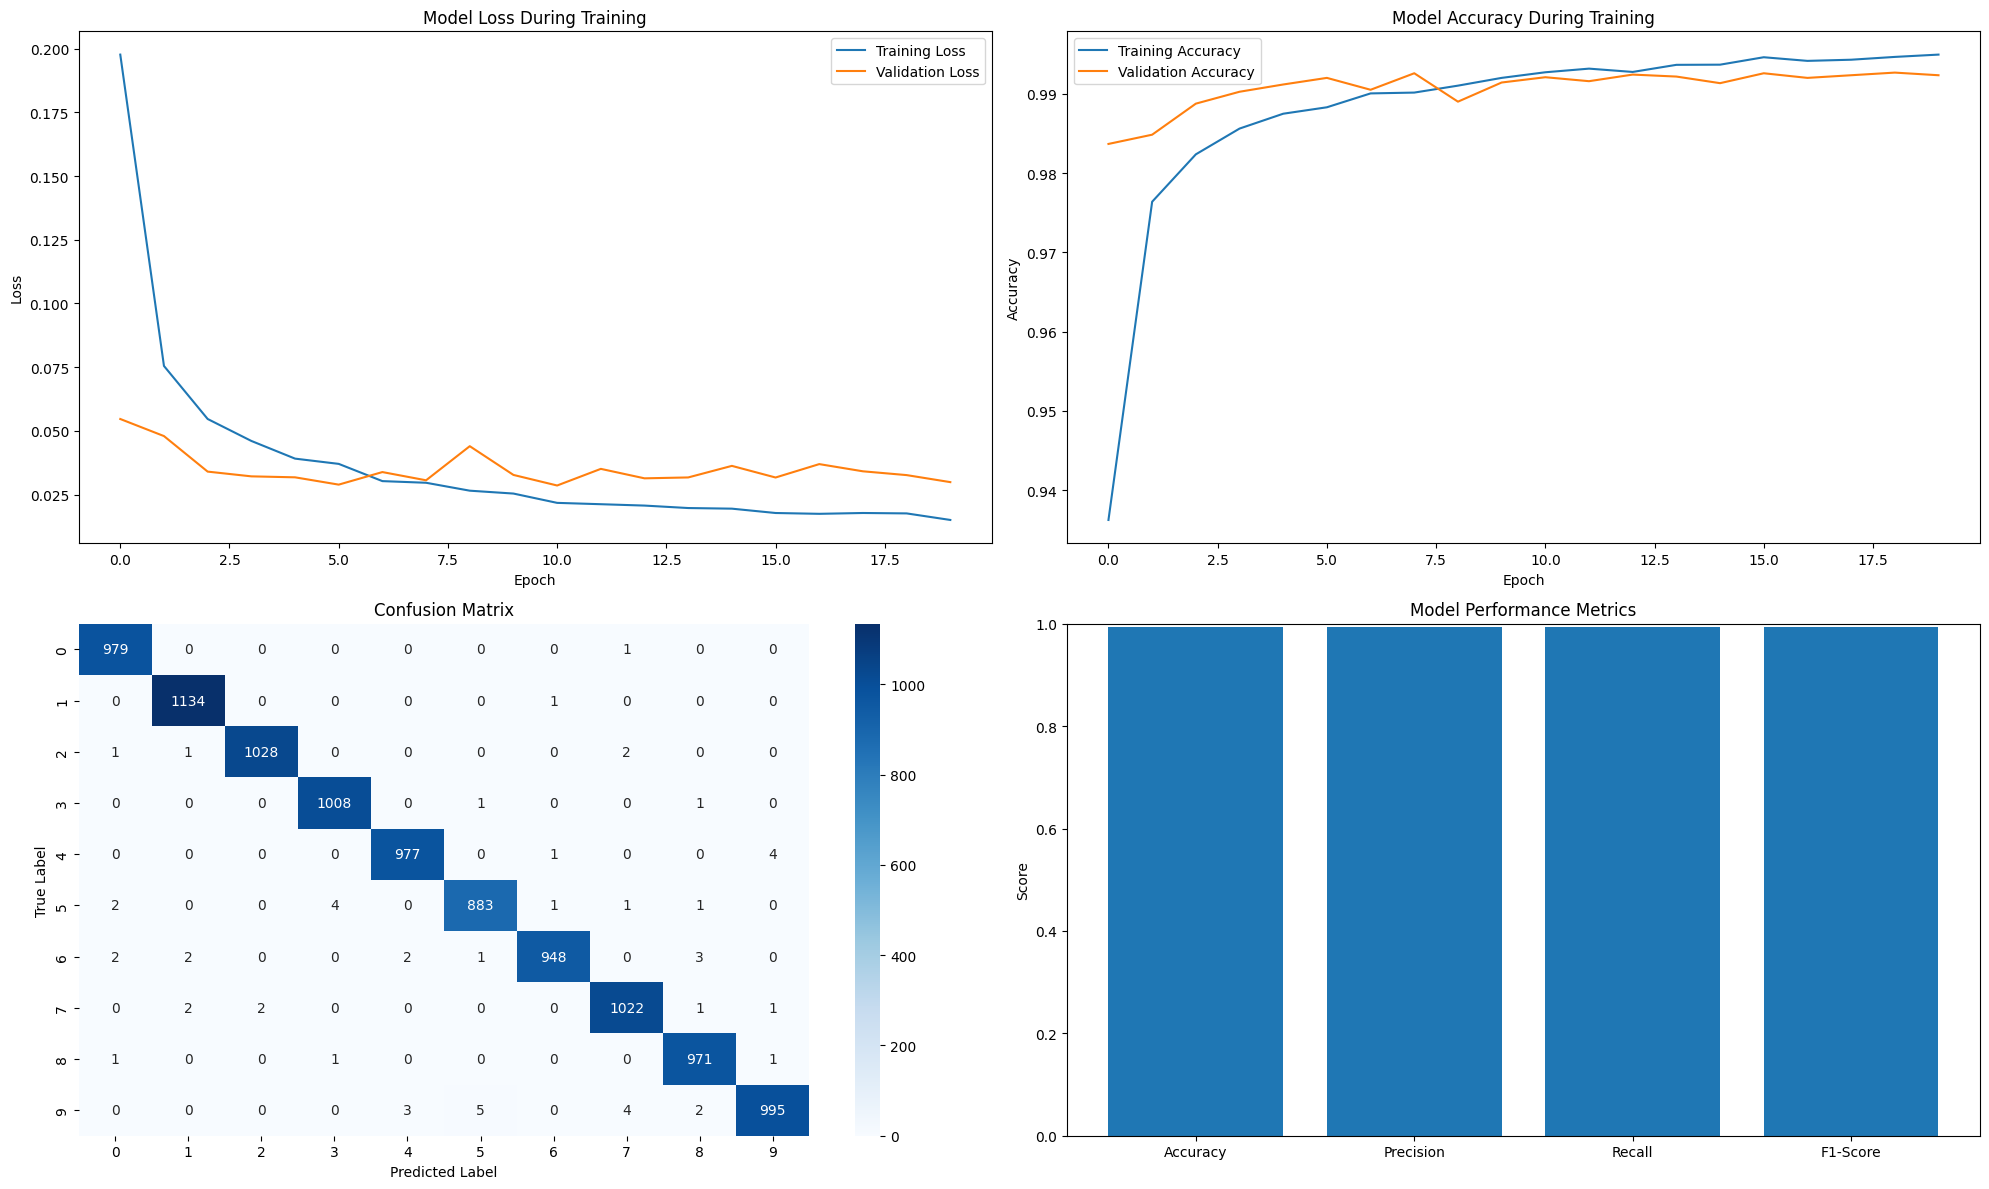

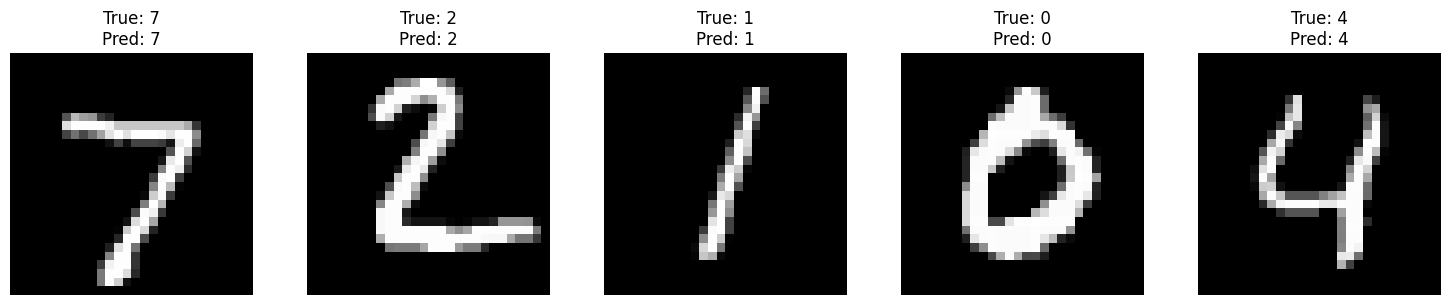

In [6]:
# Handwriting Recognition model using a hybrid CNN-SVM architecture for the MNIST dataset
#libraries to be used for this project are imported below
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration class to store the training and model parameters
class Config:
    # Data parameters
    IMG_HEIGHT = 28
    IMG_WIDTH = 28
    NUM_CHANNELS = 1
    NUM_CLASSES = 10

    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 20
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.1

    # These parameters will prevent ovverfitting
    DROPOUT_RATE = 0.3
    LEARNING_RATE = 0.001

    # Data augmentation was also added to improve the model's robustness
    ROTATION_RANGE = 10
    WIDTH_SHIFT_RANGE = 0.1
    HEIGHT_SHIFT_RANGE = 0.1
    ZOOM_RANGE = 0.1

# The following class is handling the MNISTdataset loading and processing
class DataLoader:
    def __init__(self, config):
        self.config = config #initialising the loader class

    def load_and_preprocess(self):
        # Load MNIST dataset and split it into testing and training sets
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        # Reshape images to include channel dimension and normalize pixels of the individual image samples
        x_train = x_train.reshape(-1, self.config.IMG_HEIGHT, self.config.IMG_WIDTH, self.config.NUM_CHANNELS)
        x_test = x_test.reshape(-1, self.config.IMG_HEIGHT, self.config.IMG_WIDTH, self.config.NUM_CHANNELS)
        x_train = x_train.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0

        # the training data is split so that we have a validation set for the model to use while evaluating  it
        x_train, x_validation, y_train, y_validation = train_test_split(
            x_train, y_train,
            test_size=self.config.VALIDATION_SPLIT,
            random_state=42
        )
        return (x_train, y_train), (x_validation, y_validation), (x_test, y_test)

    def create_data_generator(self):
        # Create data augmentation generator for training
        return ImageDataGenerator( #returs it from Keras PreProcessing module
            rotation_range=self.config.ROTATION_RANGE,
            width_shift_range=self.config.WIDTH_SHIFT_RANGE,
            height_shift_range=self.config.HEIGHT_SHIFT_RANGE,
            zoom_range=self.config.ZOOM_RANGE
        )

# The CNN (Convolutional Neural Network) is used to extract features from the number images in the MNIST dataset
class FeatureExtractorCNN(tf.keras.Model):
    def __init__(self, config):
        super(FeatureExtractorCNN, self).__init__()
        self.config = config

        # we need to add a convolutional layer to extract the  features from eah one of the images
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.dropout1 = tf.keras.layers.Dropout(config.DROPOUT_RATE)

        # the step abpve is repeated to extract as many features as possible from the images
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.dropout2 = tf.keras.layers.Dropout(config.DROPOUT_RATE)

        # the extracted features are then flattened to be used as input for the SVM with relu and softmax activation
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu') #relu activation used to prevent any possible overfitting
        self.dropout3 = tf.keras.layers.Dropout(config.DROPOUT_RATE)
        self.dense2 = tf.keras.layers.Dense(config.NUM_CLASSES, activation='softmax') # softmax activation used to classify the images into the MNIST classes, in this dataset there are only 10, from 0 to 9

    def call(self, inputs, training=False, extract_features=False): #the call function passes the input throught the network
        # Forward pass
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.dropout1(x, training=training) #dropout layer to prevent overfitting of the model data
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout2(x, training=training)
        x = self.flatten(x)
        features = self.dense1(x)
        x = self.dropout3(features, training=training)


        if extract_features:
            return features
        return self.dense2(x)


class SVMClassifier: #the SVM classifier is used to classify the extracted features from the CNN and make the model's predictions
    def __init__(self, kernel='rbf'):
        self.classifier = SVC(kernel=kernel, probability=True) #the kernel is the radial basis function, which is a popular choice for SVM models

    def train(self, features, labels):
        self.classifier.fit(features, labels) #the fit function extracts the labels from the features extracted by the CNN earlier

    def predict(self, features):
        return self.classifier.predict(features) #create predictions on the x & y testing data

    def predict_proba(self, features):
        return self.classifier.predict_proba(features)

#the evaluator will take care of the metrics and evaluation for the hybrid model
#the static method is used to call the metrics without the need to create an instance of the class itself making it easier to use
class ModelEvaluator:
    @staticmethod
    def compute_metrics(y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support( #the precision, f1 and recall are used to evaluate the performance overall
            y_true, y_pred, average='weighted' #
        )
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

    @staticmethod
    def get_confusion_matrix(y_true, y_pred): #the confusion matrix is used to evaluate the performance of the model, it shows the number of correct and incorrect predictions made
        return confusion_matrix(y_true, y_pred)

# matplotlib is used to plot the metrics and the confusion matrix into plots for easy understanding
def plot_metrics(trainHistory, metrics, confusionMatrix, y_test, predicted_labels_y):
    fig = plt.figure(figsize=(20, 12))

    # Plot training and validation loss on the same plot
    plt.subplot(2, 2, 1)
    plt.plot(trainHistory.history['loss'], label='Training Loss')
    plt.plot(trainHistory.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(trainHistory.history['accuracy'], label='Training Accuracy')
    plt.plot(trainHistory.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix as a heatmap
    # it's better to use the heatmap function because it's easier to read
    plt.subplot(2, 2, 3)
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Plot performance metrics as a bar chart
    plt.subplot(2, 2, 4)
    metric_values = [metrics['accuracy'], metrics['precision'],
                    metrics['recall'], metrics['f1']]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    plt.bar(metric_names, metric_values)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1.0)

    plt.tight_layout()
    plt.show()

# the following function is used to visualize the sample predictions made by the model
def plot_sample_predictions(x_test, y_test, predicted_labels_y, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_test[i]}\nPred: {predicted_labels_y[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main execution function
def main():
    # Initialize the configuration created earlier
    config = Config()

    # Load and preprocess our data from the MNIST dataset, imported via Keras
    loadData = DataLoader(config)
    (x_train, y_train), (x_validation, y_validation), (x_test, y_test) = loadData.load_and_preprocess()

    # Create and compile our CNN model with the configuration parameters and the Adam optimizer
    cnn = FeatureExtractorCNN(config)
    cnn.compile(
        optimizer=tf.keras.optimizers.Adam(config.LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the CNN model using the training and validation data
    trainHistory = cnn.fit(
        x_train, y_train,
        batch_size=config.BATCH_SIZE,
        epochs=config.EPOCHS,
        validation_data=(x_validation, y_validation)
    )

    # Extract features using the trained CNN model
    train_features = cnn(x_train, extract_features=True)
    validation_features = cnn(x_validation, extract_features=True)
    test_features = cnn(x_test, extract_features=True)

    # Train SVM on the extracted features from the CNN
    svm_classifier = SVMClassifier()
    svm_classifier.train(train_features.numpy(), y_train) #numpy is used to convert the features into a numpy array for the SVM to use

    # Make predictions using our hybrid model
    predicted_labels_y = svm_classifier.predict(test_features.numpy())

    # Evaluate model performance using the metrics and confusion matrix
    evaluateModel = ModelEvaluator()
    metrics = evaluateModel.compute_metrics(y_test, predicted_labels_y)
    confusionMatrix = evaluateModel.get_confusion_matrix(y_test, predicted_labels_y)

    # Print results
    print("\nModel Results:")
    for metric_name, value in metrics.items():
        print(f"{metric_name.capitalize()}: {value:.4f}")

    # Visualize results
    plot_metrics(trainHistory, metrics, confusionMatrix, y_test, predicted_labels_y)     #plotting the metrics and confusion matrix
    plot_sample_predictions(x_test, y_test, predicted_labels_y)     #plotting the sample predictions

if __name__ == "__main__":
    main()
    #the main function is called to execute the program and plot the results
